In [1]:
!pip install -q efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.7 MB/s eta 0:00:00


# Import libraries

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import efficientnet.tfkeras as efn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from numpy.lib.format import open_memmap, read_array_header_1_0
import io
from sklearn.utils import class_weight
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

2025-06-11 08:43:22.387018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749631402.594435      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749631402.658431      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Check the header size
example_path = '../input/seti-breakthrough-listen/train/0/002efdabe4e3e45.npy'

with open(example_path, 'rb') as f:
    magic = f.read(6)
    version = f.read(2)
    header_len_bytes = f.read(2)
    header_len = int.from_bytes(header_len_bytes, 'little')

    header = f.read(header_len)
    print(f"Header: {header.decode('latin1')}")

    total_header_bytes = 6 + 2 + 2 + header_len
    print(f"Sum size header: {total_header_bytes}")

Header: {'descr': '<f2', 'fortran_order': False, 'shape': (6, 273, 256), }                                                   

Sum size header: 128


# Build the functions

In [4]:
# Decoder function
def build_decoder(with_labels = True, target_size=(256, 256), ext='npy'):
    def decode(path):
        file_bytes = tf.io.read_file(path)

        if ext == 'npy':
            header_size = 128
            
            data_bytes = tf.strings.substr(file_bytes, header_size, -1)
            img = tf.io.decode_raw(data_bytes, tf.float16)
            
            img = tf.reshape(img, [6, 273, 256])
            r = tf.concat([img[0], img[1]], axis =0)
            g = tf.concat([img[2], img[3]], axis =0)
            b = tf.concat([img[4], img[5]], axis =0)
            img = tf.stack([r, g, b], axis=-1)
        else:
            if ext == 'png':
                img = tf.image.decode_png(file_bytes, channels = 3)
            elif ext in ['jpg', 'jpeg']:
                img = tf.image.decode_jpeg(file_bytes, channels = 3)
            else:
                raise ValueError("Image extension not supported")
                
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img

    def decode_with_labels(path, label):
        return decode(path), tf.cast(label, tf.float32)

    return decode_with_labels if with_labels else decode

In [5]:
# Augmenter function
def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.cast(img, tf.float32)
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), tf.cast(label, tf.float32)
    
    return augment_with_labels if with_labels else augment

In [6]:
# Dataset function
def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

# Simple EDA and data visualisation

In [7]:
data_dir = Path('../input/seti-breakthrough-listen/')

train_data_dir = data_dir / 'train'
test_data_dir = data_dir / 'test'
train_label_file = data_dir / 'train_labels.csv'
sample_sub = data_dir / 'sample_submission.csv'

In [8]:
df_train = pd.read_csv(train_label_file)
df_train

id  target
0      0000799a2b2c42d       0
1      00042890562ff68       0
2      0005364cdcb8e5b       0
3      0007a5a46901c56       0
4      0009283e145448e       0
...                ...     ...
59995  fff8217fe05aba3       0
59996  fffa939e610ed70       0
59997  fffbb1c9c3d6c31       1
59998  fffc9a763d23647       0
59999  ffff0a799efa529       0

[60000 rows x 2 columns]

In [9]:
# ID to path function
def id_to_path(file_id):
    return str(train_data_dir / file_id[0] / f"{file_id}.npy")

df_train["path"] = df_train["id"].apply(id_to_path)
df_train['group'] = df_train['id'].str[0]

target
0    54000
1     6000
Name: count, dtype: int64


Text(0.5, 1.0, 'Target Distribution')

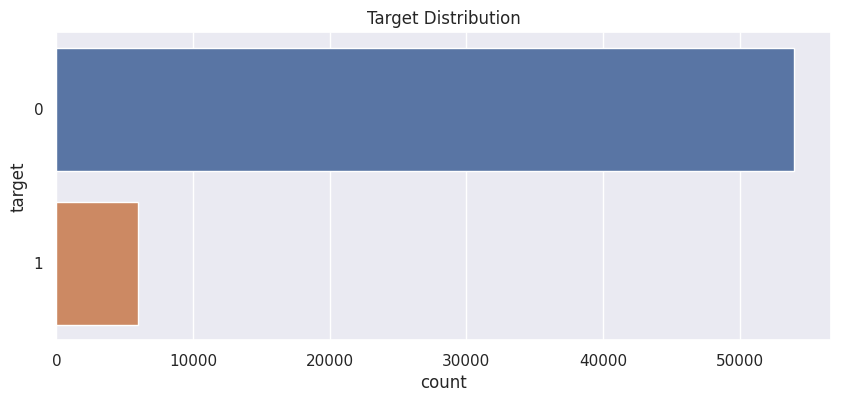

In [11]:
# Target distribution
print(df_train.target.value_counts())

plt.figure(figsize=(10, 4))
sns.countplot(y="target", data=df_train)
plt.title("Target Distribution")

In [12]:
# Visualisation functions
def show_channels(filename: str, label: int) -> None:
    plt.figure(figsize=(16, 10))
    plt.suptitle(f"ID: {os.path.basename(filename)} TARGET: {label}", fontsize=18)
    arr = np.load(filename)
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(arr[i].astype(float), cmap="magma")
        plt.title(f"Cadence {i}", fontsize=12)
        plt.xlabel("Time", size =10)
        plt.ylabel("Frequency", size =10)
        plt.grid(False) 
    plt.show()

def show_cadence(filename: str, label: int) -> None:
    plt.figure(figsize=(16, 10))
    arr = np.load(filename)
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        if i == 0:
            plt.title(f"ID: {os.path.basename(filename)} TARGET: {label}", fontsize=18)
        plt.imshow(arr[i].astype(float), interpolation='nearest', aspect='auto', cmap ='viridis')
        plt.text(5, 100, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'})
        plt.xticks([])
        plt.grid(False)
    plt.show()

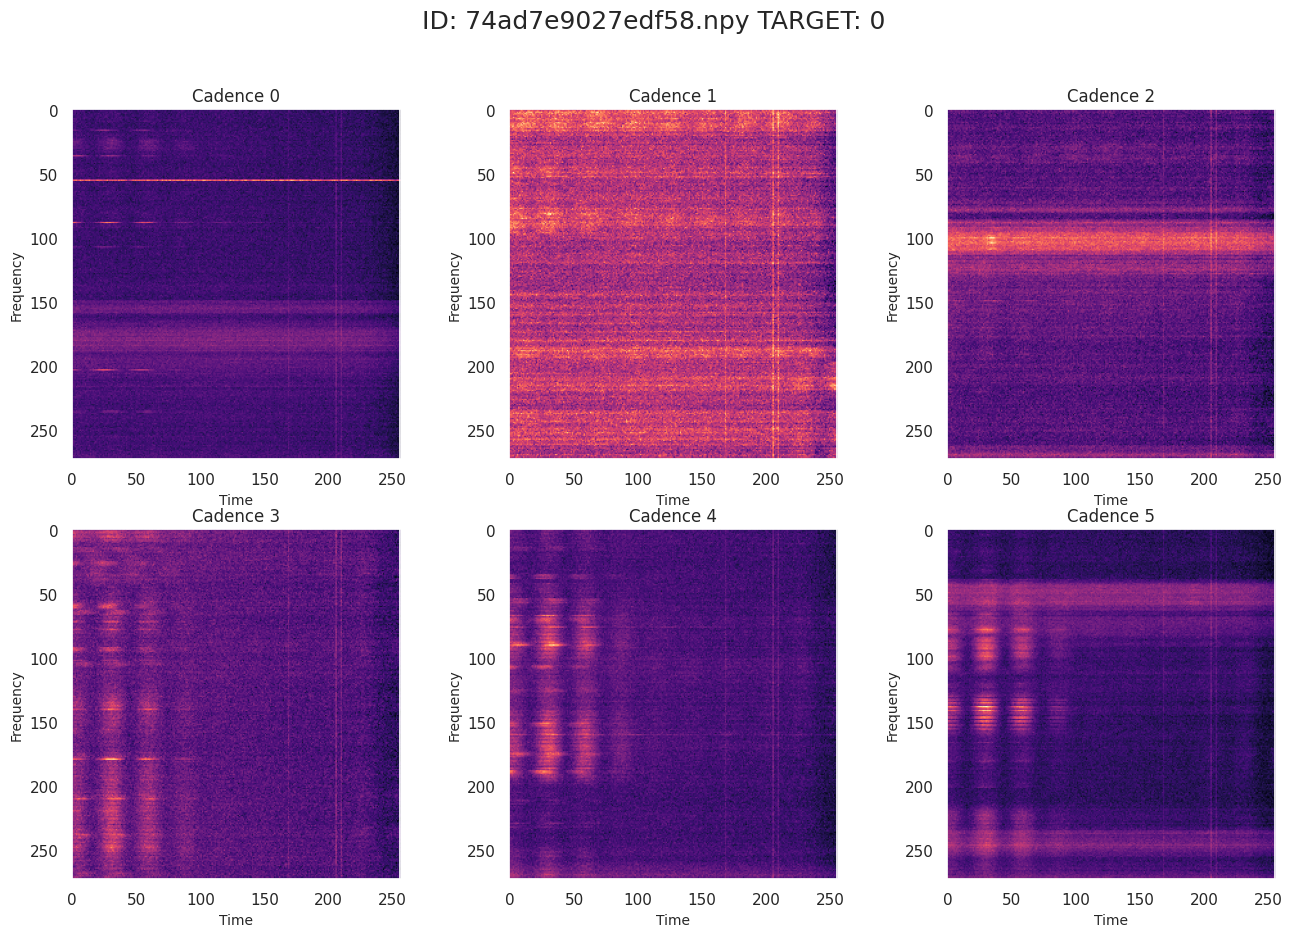

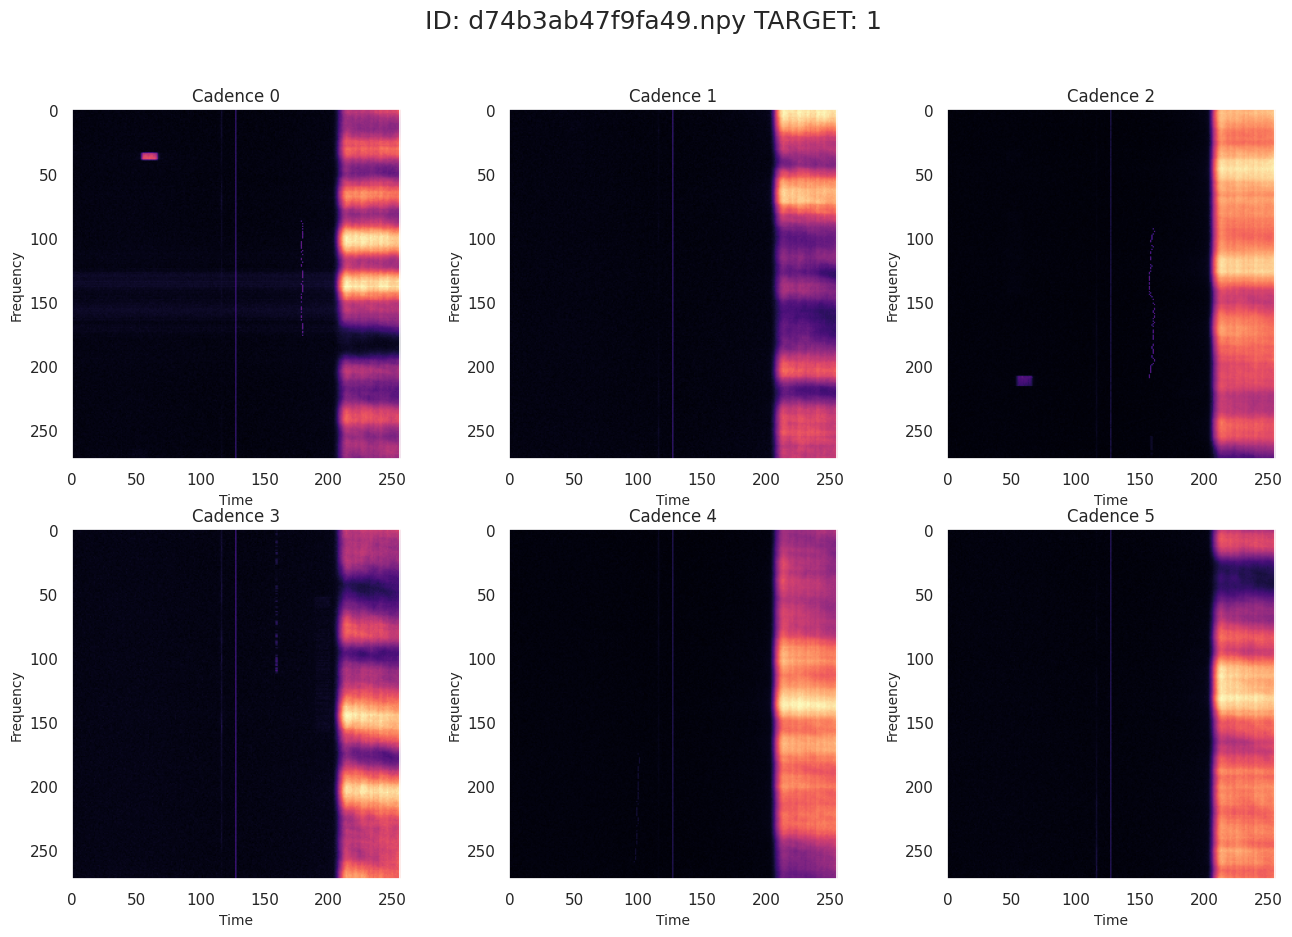

In [17]:
df_tmp = df_train[df_train["target"] == 0].sample(1)
for ind, row in df_tmp.iterrows():
    show_channels(id_to_path(row["id"]), row["target"])

df_tmp = df_train[df_train["target"] == 1].sample(1)
for ind, row in df_tmp.iterrows():
    show_channels(id_to_path(row["id"]), row["target"])

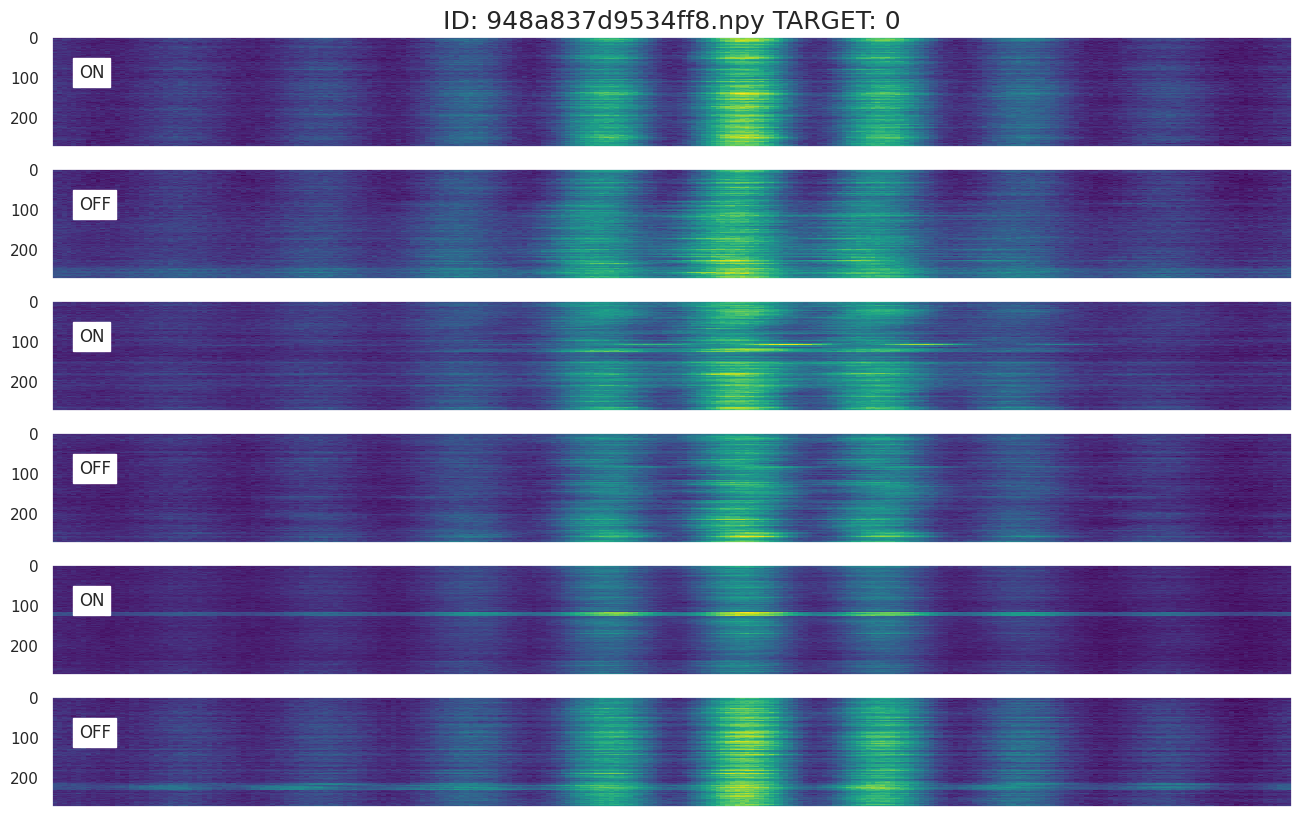

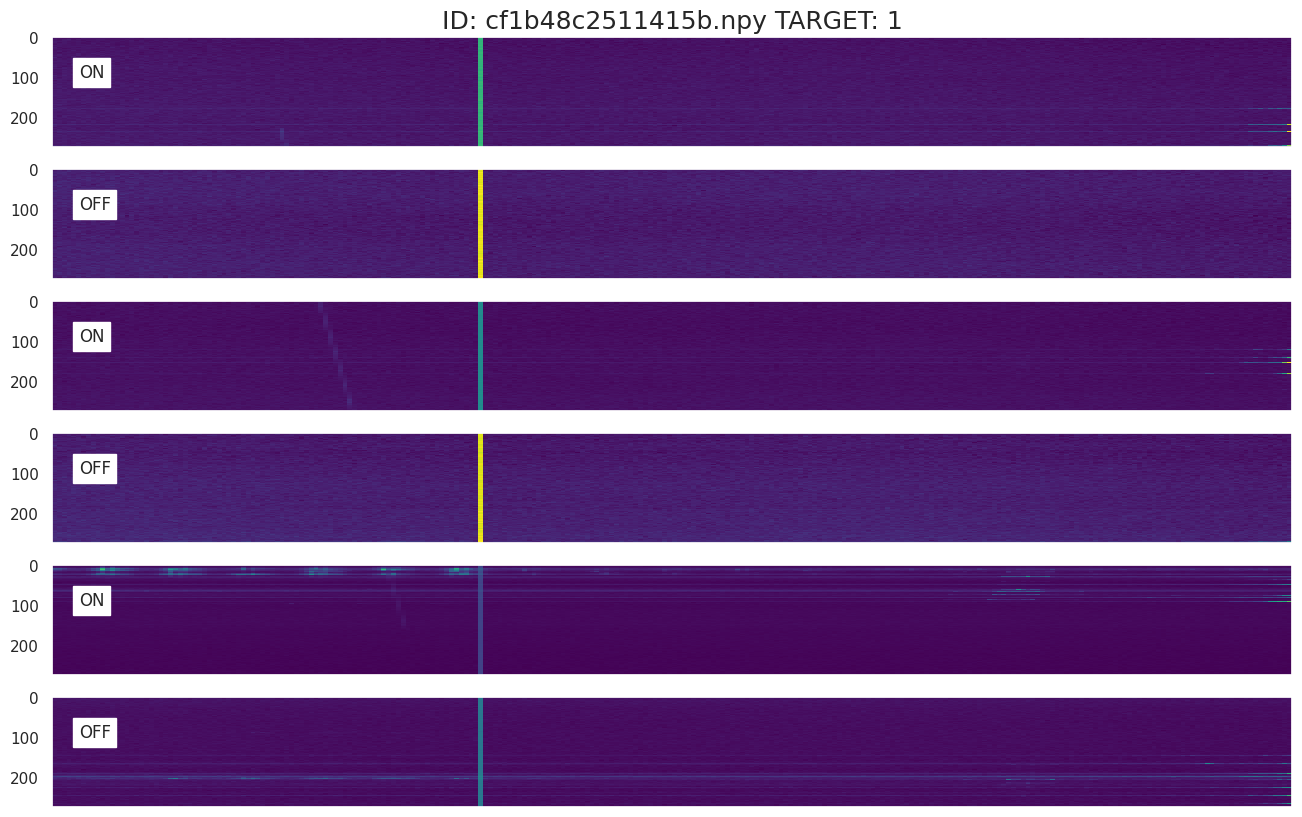

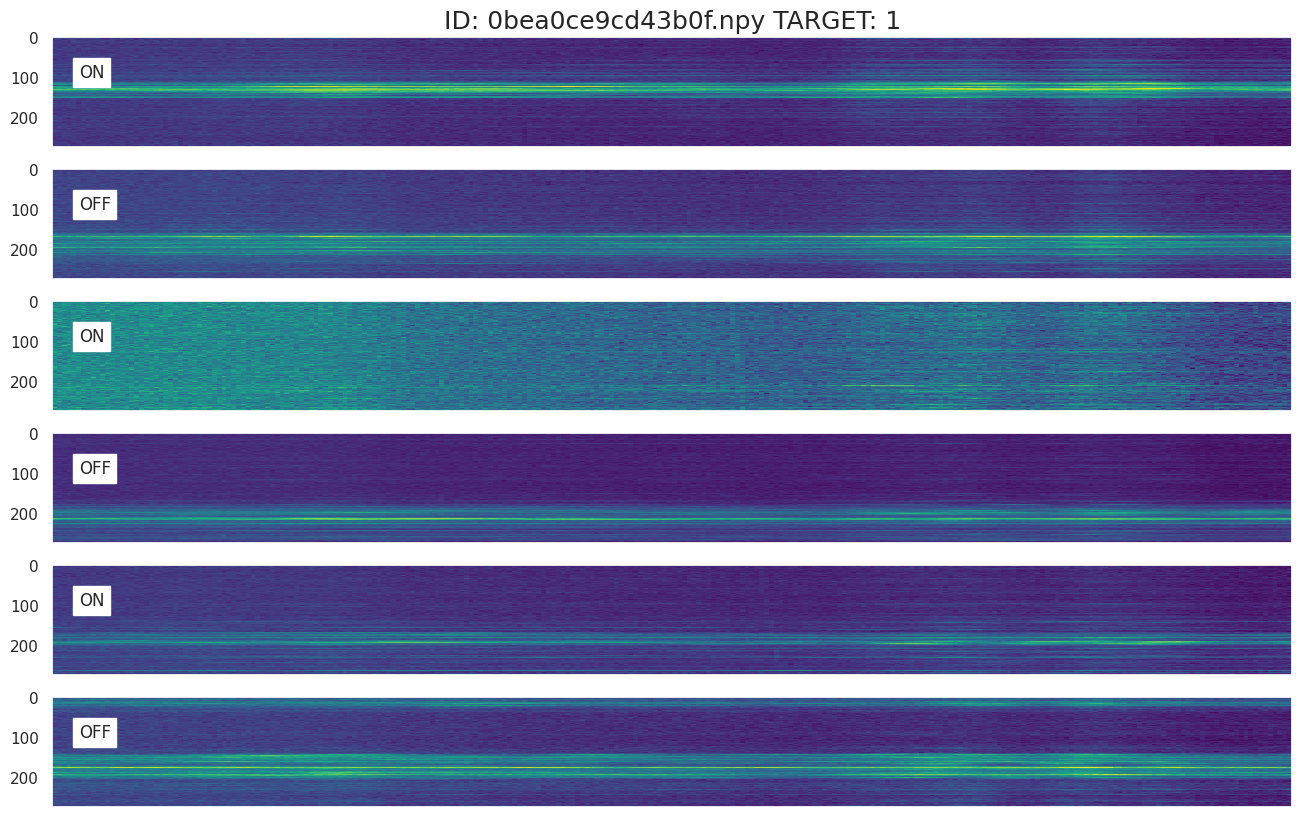

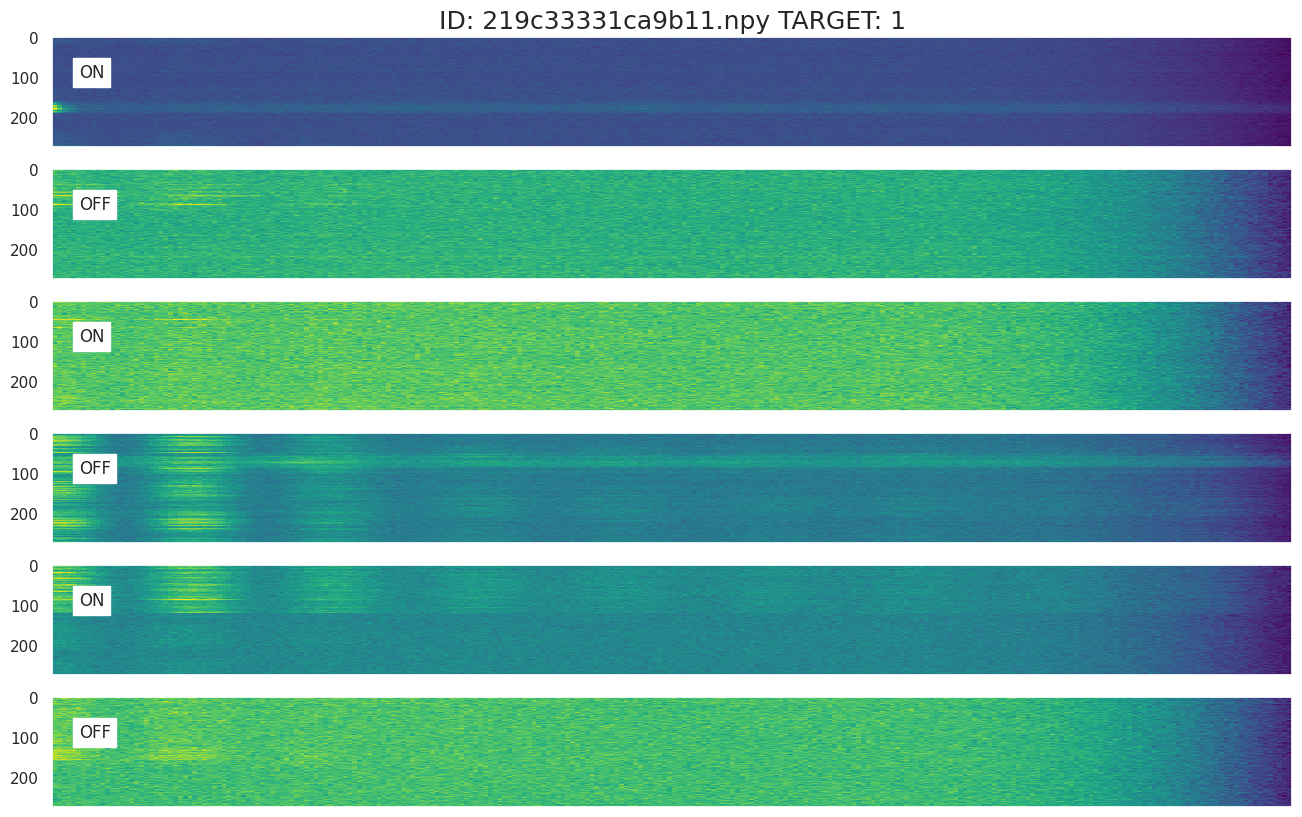

In [18]:
df_tmp = df_train[df_train["target"] == 0].sample(1)
for ind, row in df_tmp.iterrows():
    show_cadence(id_to_path(row["id"]), row["target"])

df_tmp = df_train[df_train["target"] == 1].sample(3)
for ind, row in df_tmp.iterrows():
    show_cadence(id_to_path(row["id"]), row["target"])

# GroupKFold
- We will split our dataset into 3 folds and train 3 different models

In [10]:
BATCH_SIZE = 128

N_SPLITS = 3
gkf = GroupKFold(n_splits = N_SPLITS)
df_train['fold'] = -1

for fold, (train_idx, val_idx) in enumerate(gkf.split(df_train, groups =df_train['group'])):
    df_train.loc[val_idx, 'fold']= fold

df_train['fold'].value_counts()

fold
2    22426
1    18803
0    18771
Name: count, dtype: int64

In [11]:
# Check the fold distribution
fold_distribution = df_train.groupby(['fold', 'target']).size().unstack(fill_value=0)
print(fold_distribution)

target      0     1
fold               
0       16910  1861
1       16884  1919
2       20206  2220


# Build and train the EfficientNet Model

In [12]:
def build_model(input_shape=(260, 260, 3), n_labels=1, weights='imagenet'):
    
    inputs = tf.keras.Input(shape=input_shape)

    x = efn.EfficientNetB2(
        input_shape=input_shape,
        weights=weights,
        include_top=False
    )(inputs)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(n_labels, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    
    return model

In [13]:
for i in range(3):
    fold = i
    print(f"\n📦 Training on fold {fold}")
    tf.keras.backend.clear_session()

    val_paths = df_train[df_train["fold"] == fold]["path"].values
    val_labels = df_train[df_train["fold"] == fold]["target"].values
    
    train_paths = df_train[df_train["fold"] != fold]["path"].values
    train_labels = df_train[df_train["fold"] != fold]["target"].values

    decoder = build_decoder(with_labels = True, target_size=(260, 260), ext = 'npy')

    train_dataset = build_dataset(
        train_paths, train_labels, bsize=BATCH_SIZE, decode_fn=decoder, repeat=True, cache_dir='/kaggle/tf_cache')

    valid_dataset = build_dataset(
        val_paths, val_labels, bsize=BATCH_SIZE, decode_fn=decoder, repeat=False, shuffle=False, augment=False, cache_dir='/kaggle/tf_cache')

    steps_per_epoch = train_paths.shape[0] // BATCH_SIZE

    try:
        n_labels = train_labels.shape[1]
    except:
        n_labels = 1

    model = build_model()

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate = 3e-4,
        decay_steps=steps_per_epoch * 20,
        alpha = 5e-5)

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss = 'binary_crossentropy',
        metrics = [tf.keras.metrics.AUC(name = 'auc')])

    model.summary()

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f'model_fold_{fold}.h5', save_best_only=True, save_weights_only=False, monitor='val_auc', mode='max')

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels)

    class_weights = dict(enumerate(class_weights))
    print(class_weights)

    history = model.fit(
        train_dataset,
        validation_data = valid_dataset,
        epochs=15,
        verbose=1,
        callbacks=[checkpoint],
        steps_per_epoch = steps_per_epoch)


📦 Training on fold 0


I0000 00:00:1749631459.725355      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


31936256/31936256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 260, 260, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnet-b2 (Functional)         │ (None, 9, 9, 1408)          │       7,768,562 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,409 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,769,971 (29.64 MB)

 Trainable params: 7,702,403 (29.38 MB)

 Non-trainable params: 67,568 (263.94 KB)

{0: 0.5557967107036937, 1: 4.980550857695095}
Epoch 1/15


I0000 00:00:1749631543.294018      84 service.cc:148] XLA service 0x7aca30004550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749631543.294985      84 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749631550.242618      84 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1749631575.121752      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749631575.330178      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749631576.330734      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749631576.5542

322/322 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - auc: 0.4910 - loss: 0.3671 - val_auc: 0.5063 - val_loss: 0.3324
Epoch 2/15
322/322 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - auc: 0.5946 - loss: 0.3146 - val_auc: 0.6636 - val_loss: 0.2982
Epoch 3/15
322/322 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - auc: 0.7032 - loss: 0.2719 - val_auc: 0.7437 - val_loss: 0.2756
Epoch 4/15
322/322 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - auc: 0.7302 - loss: 0.2588 - val_auc: 0.7769 - val_loss: 0.2456
Epoch 5/15
322/322 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - auc: 0.7516 - loss: 0.2501 - val_auc: 0.7936 - val_loss: 0.2344
Epoch 6/15
322/322 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - auc: 0.7777 - loss: 0.2369 - val_auc: 0.8103 - val_loss: 0.2305
Epoch 7/15
322/322 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - auc: 0.8025 - loss: 0.2306 - val_auc: 0.8385 - val_loss: 0.2151
Epoch 8/15
322/322 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - auc: 0.8227 - loss: 0.2182 - val_auc: 0.8638 - val_loss: 0.2045
Epoch 9/15
322/322 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - auc:

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 260, 260, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnet-b2 (Functional)         │ (None, 9, 9, 1408)          │       7,768,562 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,409 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,769,971 (29.64 MB)

 Trainable params: 7,702,403 (29.38 MB)

 Non-trainable params: 67,568 (263.94 KB)

{0: 0.5549762905485505, 1: 5.047414849301642}
Epoch 1/15
321/321 ━━━━━━━━━━━━━━━━━━━━ 496s 1s/step - auc: 0.4928 - loss: 0.3720 - val_auc: 0.5042 - val_loss: 0.3314
Epoch 2/15
321/321 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - auc: 0.5890 - loss: 0.3130 - val_auc: 0.6477 - val_loss: 0.4009
Epoch 3/15
321/321 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - auc: 0.6962 - loss: 0.2732 - val_auc: 0.7469 - val_loss: 0.2586
Epoch 4/15
321/321 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - auc: 0.7368 - loss: 0.2558 - val_auc: 0.7739 - val_loss: 0.2403
Epoch 5/15
321/321 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - auc: 0.7639 - loss: 0.2456 - val_auc: 0.7956 - val_loss: 0.2330
Epoch 6/15
321/321 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - auc: 0.7783 - loss: 0.2380 - val_auc: 0.8182 - val_loss: 0.2235
Epoch 7/15
321/321 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - auc: 0.8051 - loss: 0.2283 - val_auc: 0.8383 - val_loss: 0.2138
Epoch 8/15
321/321 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - auc: 0.8229 - loss: 0.2179 - val_auc: 0.8596 - val_loss: 0.2043
Ep

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 260, 260, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnet-b2 (Functional)         │ (None, 9, 9, 1408)          │       7,768,562 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,409 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,769,971 (29.64 MB)

 Trainable params: 7,702,403 (29.38 MB)

 Non-trainable params: 67,568 (263.94 KB)

{0: 0.555927087648695, 1: 4.97010582010582}
Epoch 1/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - auc: 0.5040 - loss: 0.3680 - val_auc: 0.4950 - val_loss: 0.3314
Epoch 2/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - auc: 0.5928 - loss: 0.3113 - val_auc: 0.6413 - val_loss: 0.3257
Epoch 3/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - auc: 0.7036 - loss: 0.2679 - val_auc: 0.7506 - val_loss: 0.2564
Epoch 4/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - auc: 0.7432 - loss: 0.2539 - val_auc: 0.7948 - val_loss: 0.2388
Epoch 5/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - auc: 0.7651 - loss: 0.2410 - val_auc: 0.8158 - val_loss: 0.2261
Epoch 6/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - auc: 0.7898 - loss: 0.2340 - val_auc: 0.8384 - val_loss: 0.2178
Epoch 7/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - auc: 0.8060 - loss: 0.2298 - val_auc: 0.8732 - val_loss: 0.2032
Epoch 8/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - auc: 0.8342 - loss: 0.2197 - val_auc: 0.8907 - val_loss: 0.1936
Epoc